# GPN Intelligence Cup 2020: Data Science

## &1. Анализ исходных данных 

In [1133]:
import pandas as pd
import numpy as np

### 1.1. Анализ данных по продажам

In [1134]:
sales = pd.read_parquet('sales.parquet')

In [1135]:
sales.shape # размер df

(5081459, 6)

In [1136]:
sales.head(5) # посмотрим на общий вид данных, в каждом из магазинов может продаваться несколько типов продукции

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0


In [1137]:
sales.isna().values.any() # отлично, пропусков в данных по продажам нет

False

In [1138]:
sales['owner'].value_counts() # все возможные владельцы магазинов

Рейдеры                       3906481
Воины полураспада              595022
Стервятники                    275076
Последователи Апокалипсиса     169120
Бомбисты                       135760
Name: owner, dtype: int64

In [1139]:
sales['goods_type'].value_counts() # все возможные типы товаров

Бензак                615722
Солярка               585314
Съедобный хлам        551292
Хлам                  540485
Патроны               505188
Броня и одежда        493856
Ядер-Кола             474912
Медпрепараты и еда    413378
Модификации тачки     353090
Жидкости для тачки    320589
Оружие                227633
Name: goods_type, dtype: int64

In [1140]:
sales['total_items_sold'].value_counts()[-1] # total_items_sold содержит отрицательные значения!

10

In [1141]:
len(set(sales['shop_id'])) # количество уникальных id магазинов

845

### 1.2. Анализ данных по характеристикам магазинов

In [1142]:
shops = pd.read_parquet('shops.parquet') 

In [1143]:
shops.head(5) # замечен первый None

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [1144]:
shops.shape # размер df

(845, 8)

In [1145]:
len(set(shops['shop_id'])) # количество строк в shops совпадает с количеством уникальных id, значит информация по характеристикам магазинов уникальна, данные есть по каждому магазину 

845

In [1146]:
shops.head(5) # замечен первый None 

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [1147]:
shops.isna().values.any() # подтверждение присутствия пропусков в данных 

True

In [1148]:
shops['year_opened'].value_counts()[:2] # в значениях года присутствуют отрицательные значения (год открытия неизвестен)!

 2139    94
-1       63
Name: year_opened, dtype: int64

In [1149]:
shops['shop_type'].value_counts() # все возможные типы машазинов

1    385
2    150
3    115
4     63
Name: shop_type, dtype: int64

In [1150]:
shops['neighborhood'].value_counts() # все возможные значения neighborhood

В центре     309
У тоннеля    169
На отшибе    115
У ночлега     81
У воды        77
Промзона      62
С краю        32
Name: neighborhood, dtype: int64

### 1.3. Анализ данных о разбивке городов по локациям

In [1151]:
cities = pd.read_parquet('cities.parquet')

In [1152]:
cities.shape # размер df

(15, 2)

In [1153]:
cities.head(5)

,city,location
0,Крепость Джита,Скалистый Могильник
1,Суховей,Скалистый Могильник
2,Храм Фритюра,Скалистый Могильник
3,Убежище Жестянщика,Свистящие Степи
4,Газтаун,Радиоактивная Пустошь


## &2. Выбор информативных признаков

In [1154]:
from sklearn import preprocessing

### 2.1 Формирование признаков по типам продаваемой продукции

* Из таблицы sales видно, что в каждом из магазинов может продаваться несколько видов товара. Возможно, разные магазины специализируются на разных видах товаров, поэтому вклад признака __"вид товара"__, несомненно,  __будет влиять на результат итоговой кластеризации магазинов__
* Разбиение кластеров по типам продукции интуитивно логично. Например, в магазинах, специализирующихся на "Съедобном хламе", можно проводить одни промоакции и выстраивать определенные макркетинговые стратегии, а в магазинах, специализирующихся на "Солярке", будут использоваться совершеннно другие стратегии. 

In [1155]:
# группирую данные, так, что каждому id соответствует уникальный тип товара и сумма всех проданных товаров данного типа товара
shop_info = sales.groupby(['shop_id','goods_type'], as_index=False).aggregate({'total_items_sold' : 'sum'})

In [1156]:
shop_info.head(10) # полученная группировка

,shop_id,goods_type,total_items_sold
0,0,Бензак,11647666.0
1,0,Броня и одежда,81.0
2,0,Жидкости для тачки,35.0
3,0,Съедобный хлам,1077.0
4,0,Хлам,1351.0
5,1,Бензак,9079168.0
6,1,Броня и одежда,1236.0
7,1,Жидкости для тачки,298.0
8,1,Солярка,1548661.0
9,1,Съедобный хлам,20340.0


In [1191]:
goods = set(shop_info['goods_type']) # получаю множество уникалных типов товаров
ids = set(shop_info['shop_id']) # получаю множество уникальных shop id  
X = pd.DataFrame({"shop_id":pd.Series(list(ids))}) # создаю колонку со списком shop_id, чтобы потом добавлять к ней сформированные признаки признаки

In [1192]:
# поочередно создаю колонки вида shop_id - количество проданного товара определенного типа и добавляю их к X
for type_i in goods:
    feature = sales[sales['goods_type'] == type_i].groupby('shop_id').aggregate({'total_items_sold' : 'sum'})
    feature = feature.rename(columns={'total_items_sold': type_i})
    X = pd.merge(left=X, right=feature, left_on='shop_id', right_on='shop_id',  how='outer')

In [1193]:
# таким образом, X содержит информацию о количестве проданного товара определенного типа по каждому shop_id
X.head(10) 

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие
0,0,81.0,NaN,NaN,NaN,NaN,35.0,11647666.0,1077.0,1351.0,NaN,NaN
1,1,1236.0,NaN,NaN,NaN,1548661.0,298.0,9079168.0,20340.0,5321.0,NaN,NaN
2,2,21571.0,5527.0,3109.0,636472.0,1378414.0,3550.0,7953184.0,115414.0,39997.0,47141.0,2526.0
3,3,754.0,61.0,NaN,NaN,2399400.0,13286.0,23048831.0,32051.0,17724.0,5.0,30.0
4,4,13826.0,16925.0,37541.0,797282.0,3258548.0,15438.0,23389524.0,289664.0,79956.0,161995.0,844.0
5,5,38255.0,17291.0,48769.0,860789.0,2451011.0,12466.0,21835937.0,284567.0,86394.0,237754.0,8778.0
6,6,1378.0,211.0,NaN,NaN,3223573.0,4980.0,11627584.0,70612.0,18157.0,12318.0,NaN
7,7,3843.0,1675.0,111.0,102628.0,921224.0,2539.0,11104626.0,44845.0,39762.0,29458.0,476.0
8,8,4444.0,6542.0,10689.0,215113.0,997187.0,12815.0,4228536.0,237388.0,62788.0,165528.0,535.0
9,9,468.0,543.0,NaN,NaN,5883914.0,12806.0,9175262.0,80611.0,59839.0,44894.0,77.0


Требуется обработка полученных данных:
1) данные содержат nan 
2) необходима нормализация признаков: значения ячеек слишком большие, удобнее рассматривать долю каждого из типов товаров, а не количество

In [1194]:
df.head(10)

,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,...,Лагерь,Нефтеперегонный Завод,Пасть,Равнина Маяка,Свинцовая Ферма,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель
0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,1.000000,0.000092,0.000116,0.000000e+00,...,0,1,0,0,0,0,0,0,0,0
1,0.000134,0.000000,0.000000,0.000000,0.168144,0.000032,0.985760,0.002208,0.000578,0.000000e+00,...,0,1,0,0,0,0,0,0,0,0
2,0.002664,0.000683,0.000384,0.078597,0.170219,0.000438,0.982130,0.014252,0.004939,5.821388e-03,...,0,1,0,0,0,0,0,0,0,0
3,0.000033,0.000003,0.000000,0.000000,0.103541,0.000573,0.994624,0.001383,0.000765,2.157645e-07,...,0,1,0,0,0,0,0,0,0,0
4,0.000585,0.000716,0.001589,0.033738,0.137891,0.000653,0.989765,0.012258,0.003383,6.855079e-03,...,0,1,0,0,0,0,0,0,0,0
5,0.001739,0.000786,0.002217,0.039139,0.111443,0.000567,0.992844,0.012939,0.003928,1.081028e-02,...,0,1,0,0,0,0,0,0,0,0
6,0.000114,0.000017,0.000000,0.000000,0.267153,0.000413,0.963634,0.005852,0.001505,1.020853e-03,...,0,1,0,0,0,0,0,0,0,0
7,0.000345,0.000150,0.000010,0.009210,0.082670,0.000228,0.996516,0.004024,0.003568,2.643527e-03,...,0,1,0,0,0,0,0,0,0,0
8,0.001019,0.001500,0.002452,0.049338,0.228715,0.002939,0.969858,0.054447,0.014401,3.796553e-02,...,0,1,0,0,0,0,0,0,0,0
9,0.000043,0.000050,0.000000,0.000000,0.539790,0.001175,0.841738,0.007395,0.005490,4.118575e-03,...,0,1,0,0,0,0,0,0,0,0


In [1360]:
X = X.fillna(0)# заполняем nan нулями
df = X.drop(columns=['shop_id']) # убираем shop_id, нормализация данного признака не требуется 
normalized_X =pd.DataFrame(preprocessing.normalize(df), columns = df.columns) # нормализация
data1 = pd.concat([X["shop_id"], normalized_X], axis=1)

In [1361]:
data1.head(10)

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,1.000000,0.000092,0.000116,0.000000e+00,0.000000
1,1,0.000134,0.000000,0.000000,0.000000,0.168144,0.000032,0.985760,0.002208,0.000578,0.000000e+00,0.000000
2,2,0.002664,0.000683,0.000384,0.078597,0.170219,0.000438,0.982130,0.014252,0.004939,5.821388e-03,0.000312
3,3,0.000033,0.000003,0.000000,0.000000,0.103541,0.000573,0.994624,0.001383,0.000765,2.157645e-07,0.000001
4,4,0.000585,0.000716,0.001589,0.033738,0.137891,0.000653,0.989765,0.012258,0.003383,6.855079e-03,0.000036
5,5,0.001739,0.000786,0.002217,0.039139,0.111443,0.000567,0.992844,0.012939,0.003928,1.081028e-02,0.000399
6,6,0.000114,0.000017,0.000000,0.000000,0.267153,0.000413,0.963634,0.005852,0.001505,1.020853e-03,0.000000
7,7,0.000345,0.000150,0.000010,0.009210,0.082670,0.000228,0.996516,0.004024,0.003568,2.643527e-03,0.000043
8,8,0.001019,0.001500,0.002452,0.049338,0.228715,0.002939,0.969858,0.054447,0.014401,3.796553e-02,0.000123
9,9,0.000043,0.000050,0.000000,0.000000,0.539790,0.001175,0.841738,0.007395,0.005490,4.118575e-03,0.000007


### 2.2 Формирование признаков по характеристикам магазинов 

* Добавим ещё некоторые наборы признаков из данных по характеристикам магазинов. Такие признаки как neighborhood, is_on_the_road, is_with_additional_services, shop_type - носят ограмный информативный характер
* __Почему эти признаки важны?__ В реальной жизни в магазин у дома люди чаще заходят за продуктами для приготовления ужина, в магазин около бизнес-центра зайдут скорее за обедом или фруктами. Возможно, и в нашем случае в магазине "В центе" и в магазине "На отшибе" спрос на товары может сильно отличаться, поэтому признаки __neighborhood, is_on_the_road, shop_type__  могут потенциально внести огромный вклад в итоговою кластеризацию
* __is_with_additional_services__ - весомый бинарный признак. Представим ситуацию: у нас есть два типа АЗС. В АЗС первого типа на территории есть минимаркет, в АЗС другого типа соответственно минимаркета нет. Понятно, что прогнозировать спрос для этих двух типов АЗС нужно по-разному, более того, в данном случае будут использоваться разные стратегии управления и маркетинга, будут планироваться разные промокампании 


In [1362]:
shops = pd.read_parquet('shops.parquet') # заметим, что shop_id не отсортированы 
shops.head(5)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
0,705,В центре,Крепость Джита,2109,нет,да,да,1
1,601,В центре,Суховей,2137,нет,нет,нет,4
2,530,В центре,Храм Фритюра,2118,нет,нет,нет,None
3,91,В центре,Убежище Жестянщика,2135,нет,нет,да,1
4,100,На отшибе,Убежище Жестянщика,2135,да,нет,да,2


In [1363]:
shops = shops.sort_values('shop_id') # отсортируем shop_id
shops.head(5)

,shop_id,neighborhood,city,year_opened,is_on_the_road,is_with_the_well,is_with_additional_services,shop_type
259,0,В центре,Нефтеперегонный Завод,2136,нет,нет,нет,None
770,1,В центре,Нефтеперегонный Завод,2115,нет,нет,нет,None
592,2,Промзона,Нефтеперегонный Завод,2115,нет,нет,да,2
701,3,У ночлега,Нефтеперегонный Завод,2092,нет,нет,нет,3
628,4,В центре,Нефтеперегонный Завод,2108,нет,нет,да,1


In [1364]:
shops = shops.replace('да', 1) # преобразуем категориальные признаки в числовые
shops = shops.replace('нет', 0) # преобразуем категориальные признаки в числовые
shops = shops.fillna('1') # заменяем None на медианное значение shop_type
# преобразуем категориальный признак neighborhood с помощью dummy-кодирования в набор бинарных признаков
(pd.get_dummies(shops["neighborhood"])).head(5)

,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
259,1,0,0,0,0,0,0
770,1,0,0,0,0,0,0
592,0,0,1,0,0,0,0
701,0,0,0,0,0,1,0
628,1,0,0,0,0,0,0


In [1365]:
# добавим полученные признаки к признакам из пункта 2.1
neigh_id = pd.concat([shops['shop_id'], pd.get_dummies(shops["neighborhood"])], axis=1) 
data2 = pd.merge(left=data1, right=neigh_id, left_on='shop_id', right_on='shop_id',  how='outer')
data2.head(5)

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,Ядер-Кола,Оружие,В центре,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,1.000000,0.000092,0.000116,0.000000e+00,0.000000,1,0,0,0,0,0,0
1,1,0.000134,0.000000,0.000000,0.000000,0.168144,0.000032,0.985760,0.002208,0.000578,0.000000e+00,0.000000,1,0,0,0,0,0,0
2,2,0.002664,0.000683,0.000384,0.078597,0.170219,0.000438,0.982130,0.014252,0.004939,5.821388e-03,0.000312,0,0,1,0,0,0,0
3,3,0.000033,0.000003,0.000000,0.000000,0.103541,0.000573,0.994624,0.001383,0.000765,2.157645e-07,0.000001,0,0,0,0,0,1,0
4,4,0.000585,0.000716,0.001589,0.033738,0.137891,0.000653,0.989765,0.012258,0.003383,6.855079e-03,0.000036,1,0,0,0,0,0,0


* Признак __shop_type__ в данном случае является категориальнм (числовые значения лишь кодируют тип), поэтому необходимо также использовать dummy-кодирование для обработки данного признака

In [1366]:
type_id = pd.concat([shops['shop_id'], pd.get_dummies(shops["shop_type"])], axis=1) 
data3 = pd.merge(left=data2, right=type_id, left_on='shop_id', right_on='shop_id',  how='outer')
# переименуем столбцы с типом для более удобной работы
for i in range(1, 5):
    data3 = data3.rename(columns={f'{i}': f'shop_type_{i}'})
data3.head(5)

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,...,На отшибе,Промзона,С краю,У воды,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,1.000000,0.000092,0.000116,...,0,0,0,0,0,0,1,0,0,0
1,1,0.000134,0.000000,0.000000,0.000000,0.168144,0.000032,0.985760,0.002208,0.000578,...,0,0,0,0,0,0,1,0,0,0
2,2,0.002664,0.000683,0.000384,0.078597,0.170219,0.000438,0.982130,0.014252,0.004939,...,0,1,0,0,0,0,0,1,0,0
3,3,0.000033,0.000003,0.000000,0.000000,0.103541,0.000573,0.994624,0.001383,0.000765,...,0,0,0,0,1,0,0,0,1,0
4,4,0.000585,0.000716,0.001589,0.033738,0.137891,0.000653,0.989765,0.012258,0.003383,...,0,0,0,0,0,0,1,0,0,0


* добавим признаки is_on_the_road, is_with_the_well, is_with_additional_service

In [1367]:
data3 = pd.merge(left=data3, right=shops[['shop_id','is_on_the_road', 'is_with_the_well', 'is_with_additional_services']], left_on='shop_id', right_on='shop_id',  how='outer')

* добавим нормализованный признак "year", проверим информативность этого признака по построенной кластеризации

In [ ]:
# признак неинформативен!

In [1351]:
year = shops["year_opened"]
mean_value = round(shops[year!= -1]["year_opened"].mean())
year = year.replace(-1, mean_value)
year = (year-year.min())/(year.max()-year.min()) # нормализация данных
year_id = pd.concat([shops['shop_id'], year], axis=1) 
data4 = pd.merge(left=data3, right=year_id, left_on='shop_id', right_on='shop_id',  how='outer')
data4.head(5)

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,...,У ночлега,У тоннеля,shop_type_1,shop_type_2,shop_type_3,shop_type_4,is_on_the_road,is_with_additional_services,year_opened_x,year_opened_y
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,1.000000,0.000092,0.000116,...,0,0,1,0,0,0,0,0,0.898551,0.898551
1,1,0.000134,0.000000,0.000000,0.000000,0.168144,0.000032,0.985760,0.002208,0.000578,...,0,0,1,0,0,0,0,0,0.594203,0.594203
2,2,0.002664,0.000683,0.000384,0.078597,0.170219,0.000438,0.982130,0.014252,0.004939,...,0,0,0,1,0,0,0,1,0.594203,0.594203
3,3,0.000033,0.000003,0.000000,0.000000,0.103541,0.000573,0.994624,0.001383,0.000765,...,1,0,0,0,1,0,0,0,0.260870,0.260870
4,4,0.000585,0.000716,0.001589,0.033738,0.137891,0.000653,0.989765,0.012258,0.003383,...,0,0,1,0,0,0,0,1,0.492754,0.492754


* обработаем и добавим признок city

In [1288]:
city_id = pd.concat([shops['shop_id'], pd.get_dummies(shops['city'])], axis=1) 
data4 = pd.merge(left=data3, right=city_id, left_on='shop_id', right_on='shop_id',  how='outer')
data4.head(5)

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,...,Лагерь,Нефтеперегонный Завод,Пасть,Равнина Маяка,Свинцовая Ферма,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,1.000000,0.000092,0.000116,...,0,1,0,0,0,0,0,0,0,0
1,1,0.000134,0.000000,0.000000,0.000000,0.168144,0.000032,0.985760,0.002208,0.000578,...,0,1,0,0,0,0,0,0,0,0
2,2,0.002664,0.000683,0.000384,0.078597,0.170219,0.000438,0.982130,0.014252,0.004939,...,0,1,0,0,0,0,0,0,0,0
3,3,0.000033,0.000003,0.000000,0.000000,0.103541,0.000573,0.994624,0.001383,0.000765,...,0,1,0,0,0,0,0,0,0,0
4,4,0.000585,0.000716,0.001589,0.033738,0.137891,0.000653,0.989765,0.012258,0.003383,...,0,1,0,0,0,0,0,0,0,0


In [1352]:
city_id

,shop_id,1,Аэропорт,Буровая Скважина,Газтаун,Дизельные Жилы,Крепость Джита,Лагерь,Нефтеперегонный Завод,Пасть,Равнина Маяка,Свинцовая Ферма,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель
259,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
770,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
592,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
701,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
628,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,840,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
671,841,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
96,842,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
204,843,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [1384]:
data3[data3['Бензак']<0.8]['Бензак'].value_counts()

0.663376    1
0.389832    1
0.416269    1
0.569897    1
0.757151    1
0.661968    1
0.652572    1
0.797893    1
0.783005    1
0.732661    1
0.700438    1
0.794181    1
0.677795    1
0.741279    1
0.754626    1
0.633942    1
0.751682    1
0.761271    1
0.606282    1
0.783361    1
0.611787    1
0.756235    1
0.461845    1
0.664350    1
0.704181    1
0.796697    1
0.721127    1
0.793388    1
0.754751    1
0.488294    1
0.629386    1
0.766793    1
0.699473    1
0.634309    1
Name: Бензак, dtype: int64

* В столбце year_opened заменим год со значением -1 на среднее значение по столбцу год. Почему нельзя оставить -1? Векторы будут слишком непохожими

In [1311]:
year

259    0.003266
770   -0.006533
592   -0.006533
701   -0.017266
628   -0.009799
         ...   
97     0.000000
671    0.000000
96     0.000000
204    0.000000
654    0.000000
Name: year_opened, Length: 845, dtype: float64

In [1291]:
year_id = pd.concat([shops['shop_id'], year], axis=1) 
data = pd.merge(left=data, right=year_id, left_on='shop_id', right_on='shop_id',  how='outer')
data.head(5)

,shop_id,Броня и одежда,Модификации тачки,Медпрепараты и еда,Патроны,Солярка,Жидкости для тачки,Бензак,Съедобный хлам,Хлам,...,Нефтеперегонный Завод,Пасть,Равнина Маяка,Свинцовая Ферма,Суховей,Темница,Убежище Жестянщика,Храм Фритюра,Цитадель,year_opened
0,0,0.000007,0.000000,0.000000,0.000000,0.000000,0.000003,1.000000,0.000092,0.000116,...,1,0,0,0,0,0,0,0,0,0.296273
1,1,0.000134,0.000000,0.000000,0.000000,0.168144,0.000032,0.985760,0.002208,0.000578,...,1,0,0,0,0,0,0,0,0,0.258771
2,2,0.002664,0.000683,0.000384,0.078597,0.170219,0.000438,0.982130,0.014252,0.004939,...,1,0,0,0,0,0,0,0,0,0.258771
3,3,0.000033,0.000003,0.000000,0.000000,0.103541,0.000573,0.994624,0.001383,0.000765,...,1,0,0,0,0,0,0,0,0,0.217696
4,4,0.000585,0.000716,0.001589,0.033738,0.137891,0.000653,0.989765,0.012258,0.003383,...,1,0,0,0,0,0,0,0,0,0.246270


In [889]:
mean_value = round(shops[year!= -1]["year_opened"].mean())
year = year.replace(-1, mean_value) # заменяем -1 на среднее

In [890]:
year = (year - year.mean())/year.std()

In [891]:
year

0     -1.496191
1      0.608564
2     -0.819662
3      0.458225
4      0.458225
         ...   
840    0.758904
841    0.007206
842   -0.894832
843   -0.443813
844    0.307885
Name: year_opened, Length: 845, dtype: float64

## 3. Выбор метрики качества кластеризации

среднее внутрикластерное расстояние, среднее межкластерное расстояние, комбинации функционалов и коэффициент силуэта

## 4. Реализация алгоритмов кластеризации

### 4.1. DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [1368]:
df = data3.drop(columns=['shop_id']).copy()
d = df.to_numpy()

In [1375]:
dbscan = DBSCAN(eps=1.4, min_samples=5)# как выбирать параметры?
 
dbscan.fit(d)
 

algo_labels = dbscan.labels_
# Готово! Распечатаем метки принадлежности к кластерам
print(metrics.silhouette_score(d, algo_labels))
print(dbscan.labels_)

0.4884084924097239
[ 0  0  1  2  0  3  0  0  0 -1  4  0  0  5  6  6  7  8  8  9 10  7  6 11
  0  8  0 12  0  3  0  3  0  8  0  5  3  0  9 13  0 14  6  0  4  0 14 15
  7 12  7  0 12  5 11 16  0 -1 14  0  0  8  0  0  0  0  1  1 14  0 14  0
  1 17  5  1  0  1  9  8  7  0  0  1 14 11 12  9 18  0 12  0 13  5  8 12
 13  1  5 13  5  0  5  0 12 12  0 12  0  5 15  0 13  0  0  1  0  8 12  0
  0  0  0  8  0  0  0  3  0  0  0 18  0  0 18  8  0  0  8  0 11  0  0  0
  0  0 16 16 -1  0  0  9 15 18 12  0  0  0 16  0 -1  0  8  8  0 18  7 18
  9 18 18 18 13 18 12 18 18 15  8 16  2 16 -1 18 18  0  4 12 18  3  0 18
  0 10 18 18  5  9  0 18  8  1 10  9 10 10 10  0  7  2  0 10 14 10  0  0
  2  0 19 10 16  0  9  9 19 19  3 12 19  9 13 13  9  0  0  0 14 11  2  9
 13 14 14 10 10 13 10 11  2 10  9  2  9  4 16  0 10 10  9  9 19 14  9 10
  9 10  9  9 12 13 12  0  2  0  0 10  0 -1  0  0  0  7  2 19  2  0  2 12
  9 16 16  0 16 16 14 12 15  0  9 12 12 12  9 19 19  9  0  9  0  9  9 15
  0 15 12 -1 13  9 13 16 12 15  

[0.01047911 0.01147229 0.00801823 0.01092893 0.0085835  0.01007429
 0.00562059 0.0110351  0.00993076 0.01105042 0.00730109 0.1658076
 0.08702852 0.05030039 0.03022205 0.0640696  0.06164885 0.10587982
 0.11433743 0.08452381 0.06326525 0.03767509 0.01027123 0.00905091
 0.01142516]


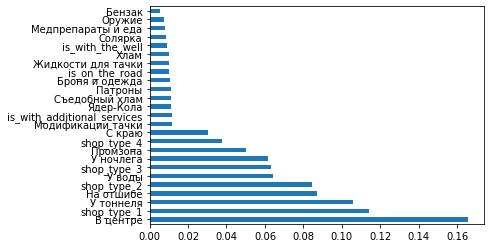

In [1379]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

# UNIVARIATE SELECTION

# data = pd.read_csv('C:\\Users\\Excel\\Desktop\\Briefcase\\PDFs\\1-ALL PYTHON & R CODE SAMPLES\\Feature Selection - Machine Learning\\train.csv')
x = df #independent columns
y = dbscan.labels_    #target column i.e price range

   
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(27).plot(kind='barh')
plt.show()

### 4.2. K-Means

In [1250]:
# Импортируем библиотеки
from sklearn import datasets
from sklearn.cluster import KMeans


# Описываем модель
model = KMeans(n_clusters=20) # подумать о количестве кластеров

# Проводим моделирование
model.fit(data)

# Предсказание на всем наборе данных
all_predictions = model.predict(data)

# Выводим предсказания

print(all_predictions)
print(metrics.silhouette_score(data, all_predictions))

[11  2  7  6 18  8  2 11 18  3  5  2  2 10 19 10 13 13 13  1  6 13 13 16
 11 13  2 17 11  8  2  8 18 13  4 19  8 18  1  3 11  5 19 11  5  2  5  2
  7 17  7  2 17 19  0  6  2 19  5 18 11 19 18 18 18 18 19 19  5 18  5  3
 19  0 19 19  2 19  1 13 13 11 18 19  5 16 12  1 19  4  0  0 12 19 19 19
  0 19 19 12 19  2 19 18 14  0  4  0  0 19 19  4 17 18 18 10 18 13  3 18
  4  4 18 10 11 18  4  8  2  2  2 13  2  2 13  2  2  2 10  2  2  4  2  2
  2  0  3  6  6  2 11  9 14  7 17  2 18  4  6 11  6 11 10 13 11 13 13  7
  9  7 13 13 17  7  0  7  7 14 13  6  6  6  3 10 13 11 14 17  7  8  2 13
 18  6 13 13 10  1 11  7  7 13  6  1  5  6  6 18 13  6  2  5  5  5 11 11
  6 11  2  5  6 11  1  9 11 11  8 17 14  9  3  3  1  2  4  4  5 16  6  0
  3  5  5  6  0 12  5  4  6  6  1  6  1  5  4  3  6  6  1  1 17  5  1  6
  1  5  1  9  3  3 17 11  6  2 11  5 18 13 11  4 11 13  6 14  6 11  6 14
  9  6  6 11  6  6  5 14 17 11  1 17 17 14  1 17 11  9  2  1  0  9  9 18
 18 11 17 16  3  9  3  5 14 18  0 17 17 14  9  3 17

### 4.3. Иерархическая кластеризация

In [1385]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [1386]:
mergings = linkage(d, method='complete')

In [1387]:
mergings

array([[4.35000000e+02, 6.32000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.48000000e+02, 7.15000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.56000000e+02, 6.12000000e+02, 4.76090838e-05, 2.00000000e+00],
       ...,
       [1.67800000e+03, 1.68500000e+03, 2.70490248e+00, 3.40000000e+02],
       [1.67900000e+03, 1.68600000e+03, 2.72106856e+00, 4.50000000e+02],
       [1.68100000e+03, 1.68700000e+03, 2.85787712e+00, 8.45000000e+02]])

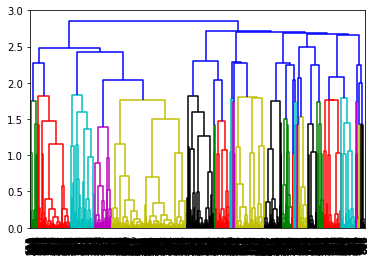

In [1388]:
dendrogram(mergings,
#            labels=varieties,
           leaf_rotation=90,
           leaf_font_size=10,
           )
# plt.figure(figsize=(20,10))
# plt.figure(figsize=(1,1))
plt.show()

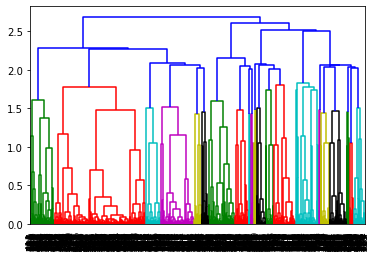

In [1276]:
dendrogram(mergings,
#            labels=varieties,
           leaf_rotation=90,
           leaf_font_size=10,
           )
# plt.figure(figsize=(20,10))
# plt.figure(figsize=(1,1))
plt.show()

In [ ]:
настоить размер:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html 

In [ ]:
повекра качества результатов 

In [545]:
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

In [600]:
alg = AgglomerativeClustering(n_clusters=5)
alg.fit(data)
alg.labels_

array([0, 0, 0, 4, 1, 1, 0, 0, 1, 3, 3, 1, 0, 0, 3, 3, 1, 0, 0, 0, 3, 3,
       0, 3, 1, 0, 1, 0, 2, 1, 1, 1, 0, 3, 1, 3, 1, 0, 1, 1, 0, 3, 1, 1,
       3, 1, 4, 0, 1, 1, 0, 1, 2, 0, 3, 3, 1, 3, 3, 1, 1, 0, 0, 1, 1, 0,
       3, 0, 4, 1, 4, 1, 0, 4, 3, 3, 1, 0, 1, 0, 3, 2, 1, 3, 3, 3, 0, 0,
       0, 1, 1, 1, 1, 3, 3, 0, 0, 0, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 1, 0,
       3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 3,
       1, 1, 3, 0, 0, 0, 3, 0, 4, 0, 1, 2, 2, 1, 4, 3, 3, 0, 1, 0, 1, 1,
       3, 0, 0, 1, 3, 1, 4, 0, 0, 0, 1, 3, 3, 0, 1, 0, 3, 3, 1, 0, 0, 0,
       0, 1, 3, 3, 3, 4, 4, 0, 3, 1, 1, 1, 0, 1, 0, 3, 1, 3, 1, 3, 1, 2,
       0, 3, 3, 3, 3, 0, 4, 3, 3, 1, 3, 4, 1, 3, 3, 3, 2, 1, 4, 1, 1, 3,
       3, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 3, 4, 3, 0, 0, 3,
       4, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 4, 1, 3, 4, 1, 0, 2, 3, 2, 3,
       1, 3, 1, 2, 1, 1, 2, 2, 3, 2, 1, 3, 2, 3, 2, 2, 1, 3, 3, 2, 3, 1,
       3, 0, 0, 3, 4, 1, 3, 4, 4, 1, 1, 2, 1, 1, 2,

In [601]:
for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=5)
    clustering.fit(data)
    
    print(metrics.silhouette_score(data, clustering.labels_))

0.12082585223821937
0.17942524589922335
0.12336133554669082
0.017129940042098838


In [ ]:
0.5494873408232994
0.5539784808859305
0.5532355555181032
0.4302314021185118

In [ ]:
варианты алгоритмов

In [ ]:
algorithms.append(KMeans(n_clusters=10, random_state=1))
algorithms.append(AffinityPropagation())
algorithms.append(SpectralClustering(n_clusters=10, random_state=1,
                                     affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=10))

In [390]:
print(metrics.silhouette_score(data2, algo_labels))
print(metrics.silhouette_score(data2, all_predictions))

0.1850243270794171
0.5344327316650442


## 5. Интерпритация результатов

In [1229]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(n_samples=500,
#                   n_features=2,
#                   centers=4,
#                   cluster_std=1,
#                   center_box=(-10.0, 10.0),
#                   shuffle=True,
#                   random_state=1)  # For reproducibility

def show_cluster(data2):
    data2 = data2.to_numpy()

    range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20, 30, 40, 50, 60, 70, 80]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data2) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(data2)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(data2, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data2, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data2[:, 0], data2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

Automatically created module for IPython interactive environment


For n_clusters = 2 The average silhouette_score is : 0.2232096623550685
For n_clusters = 3 The average silhouette_score is : 0.1997258311634608
For n_clusters = 4 The average silhouette_score is : 0.2338924646611296
For n_clusters = 5 The average silhouette_score is : 0.2605070148726348
For n_clusters = 6 The average silhouette_score is : 0.2804628494374825
For n_clusters = 7 The average silhouette_score is : 0.2874983120223077
For n_clusters = 8 The average silhouette_score is : 0.28875427347349397
For n_clusters = 9 The average silhouette_score is : 0.3272034126580811
For n_clusters = 10 The average silhouette_score is : 0.3282723894434815
For n_clusters = 11 The average silhouette_score is : 0.3486374600697091
For n_clusters = 12 The average silhouette_score is : 0.36073331843654305
For n_clusters = 20 The average silhouette_score is : 0.48467186281431246
For n_clusters = 30 The average silhouette_score is : 0.6154863351652431
For n_clusters = 40 The average silhouette_score is : 0.

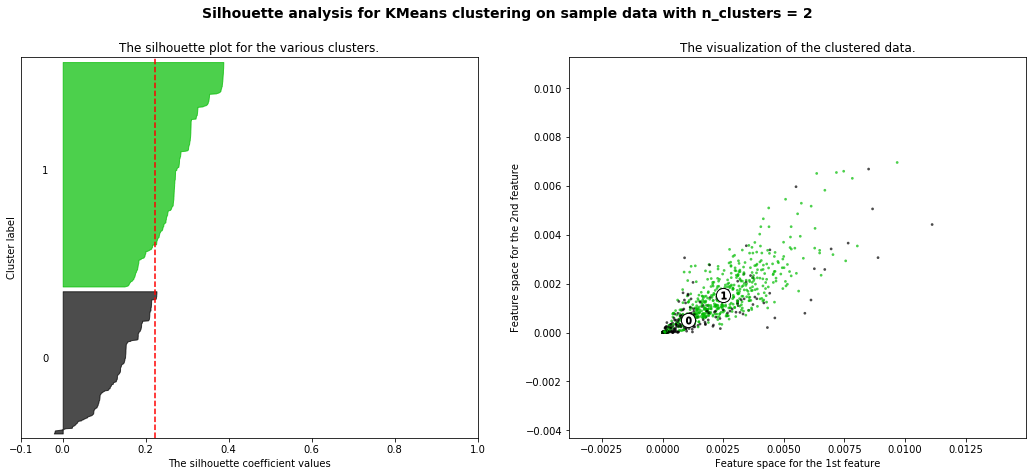

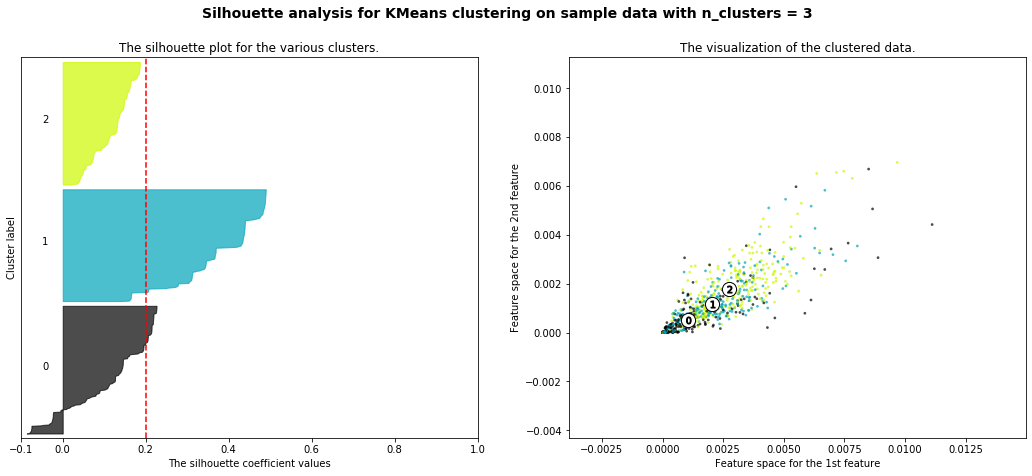

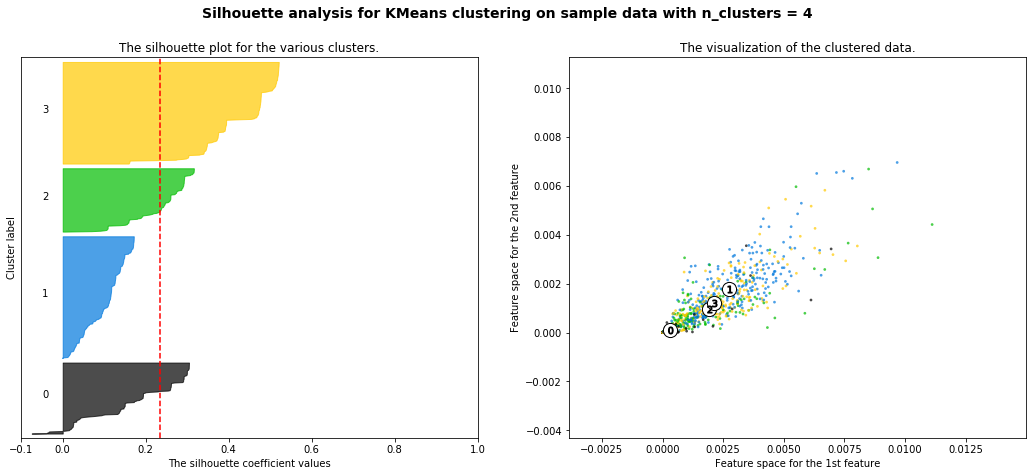

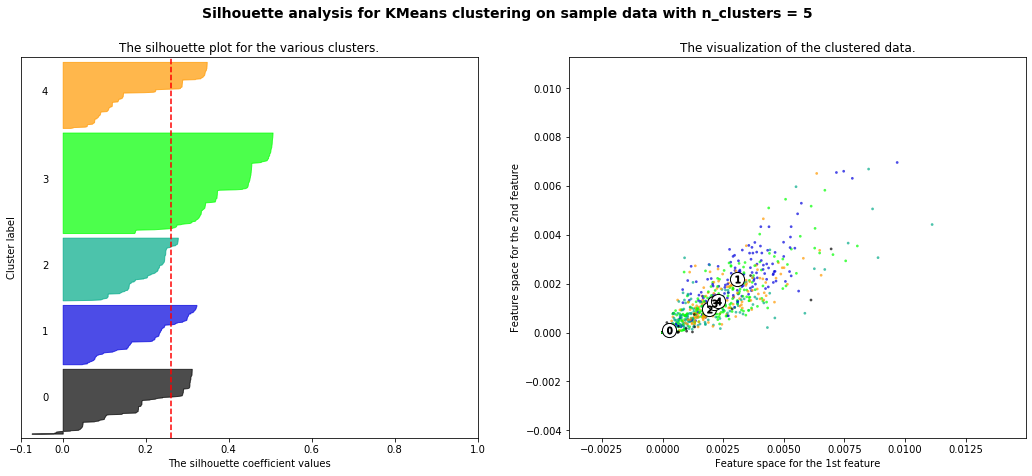

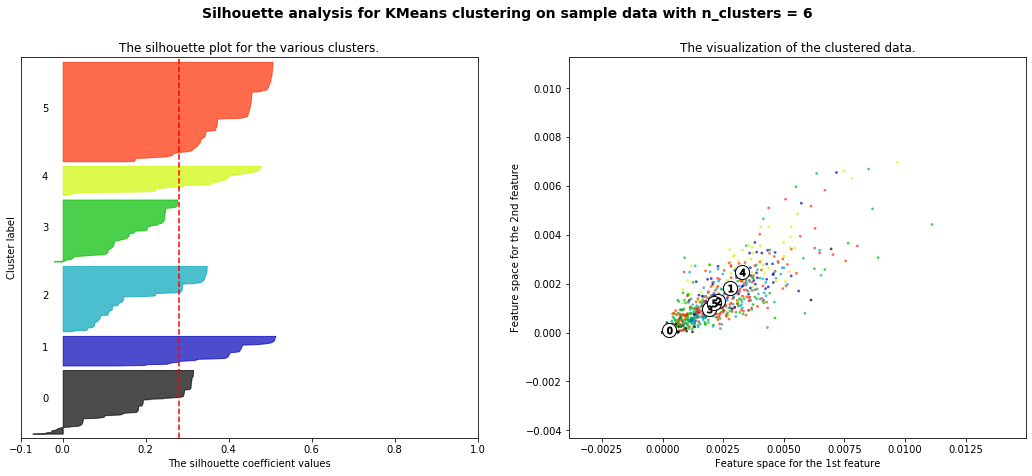

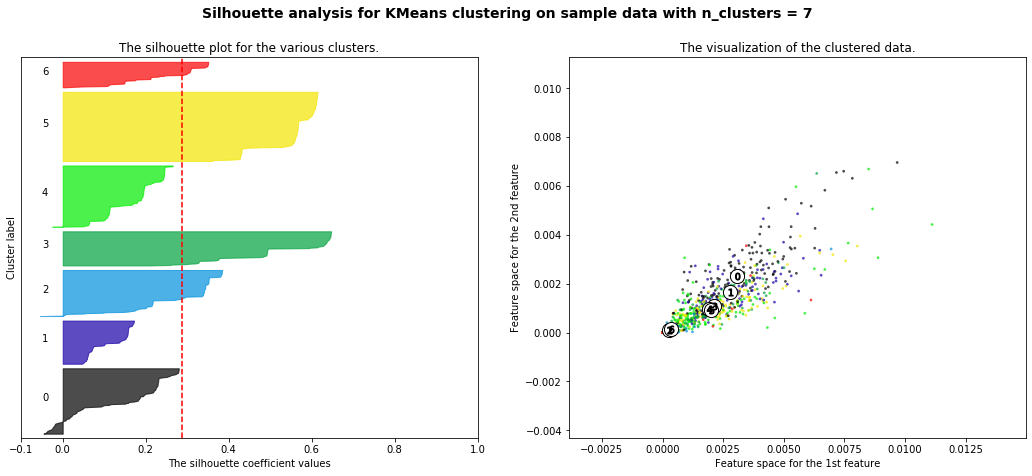

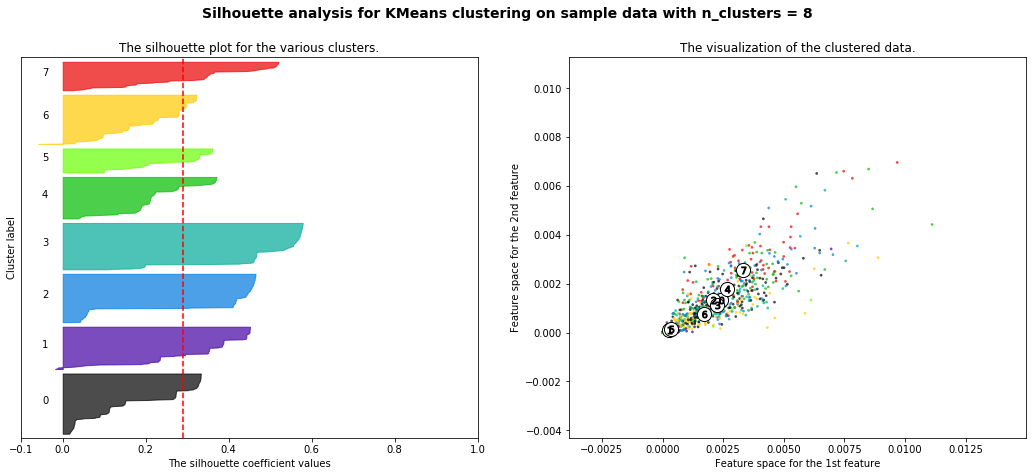

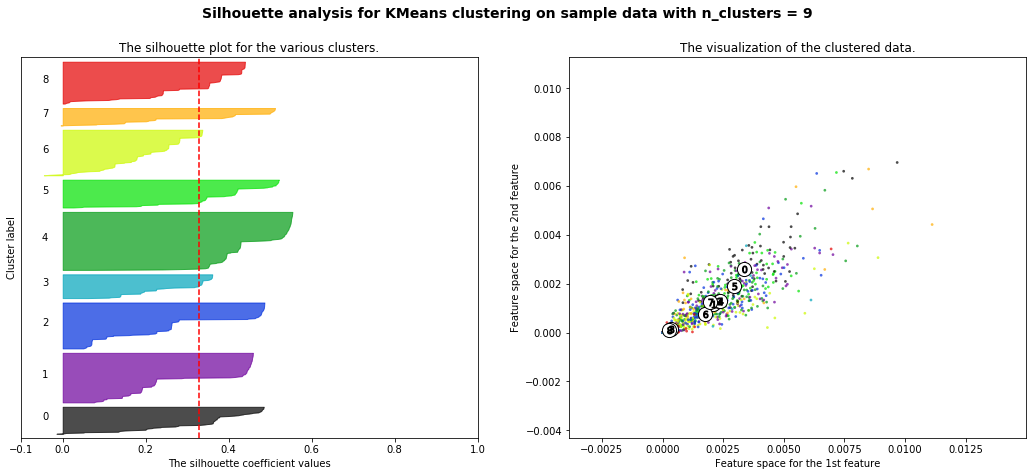

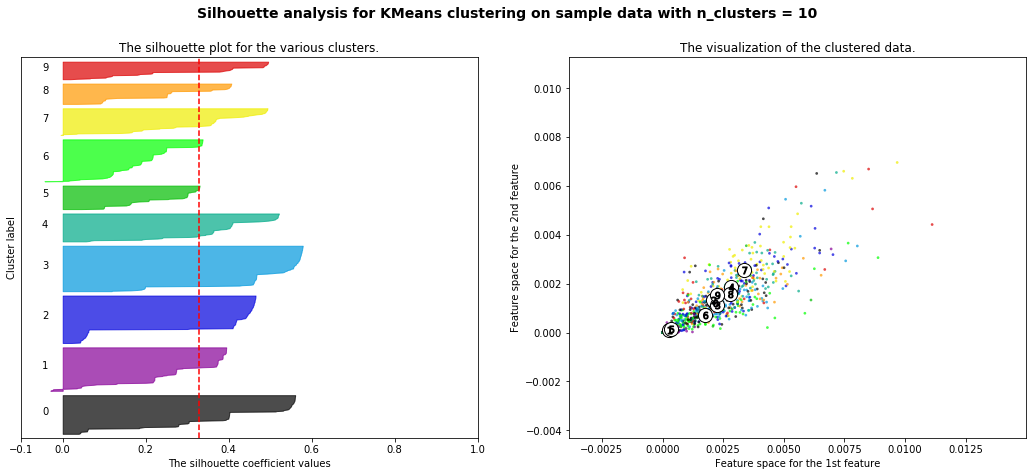

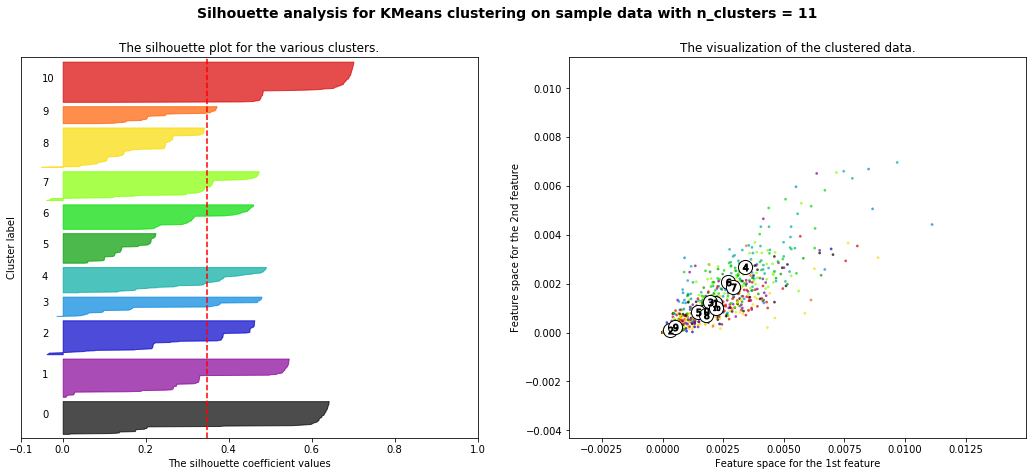

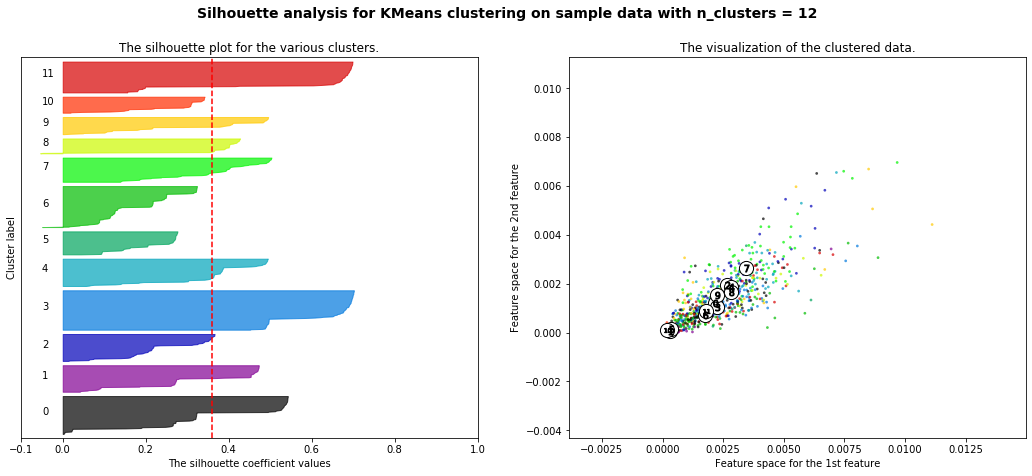

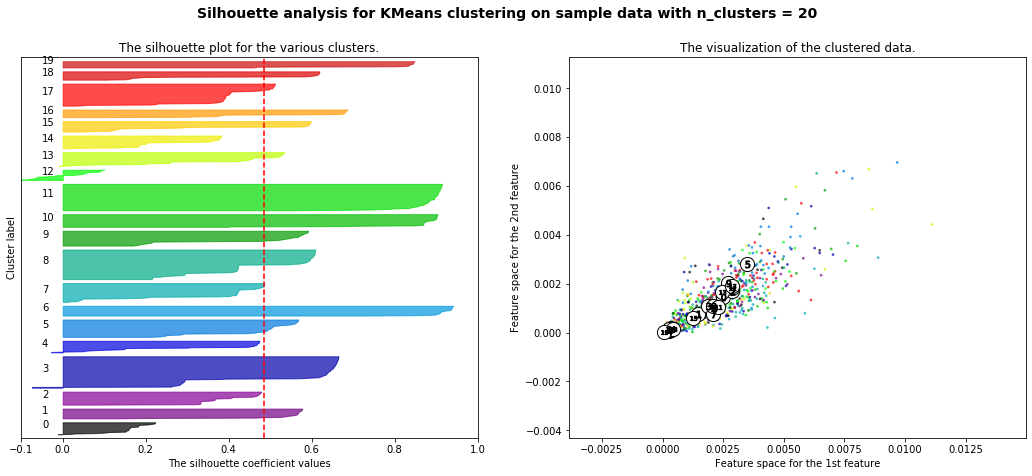

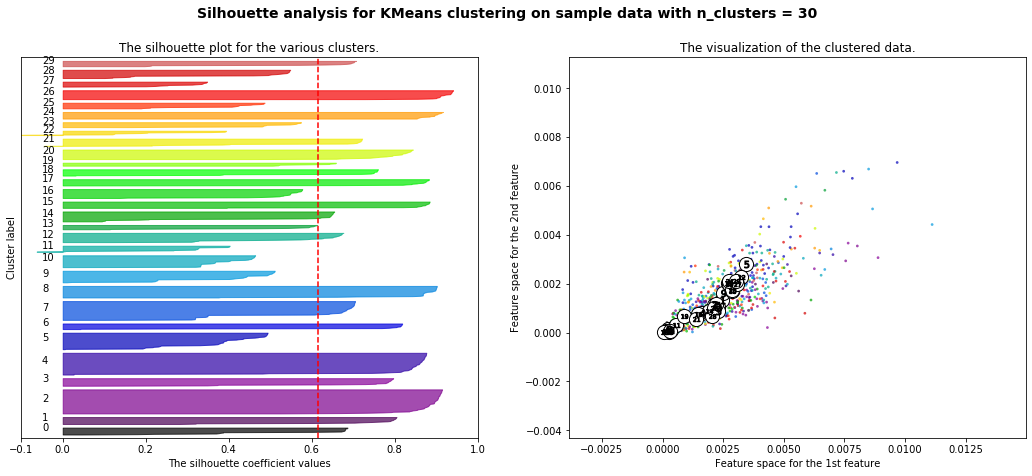

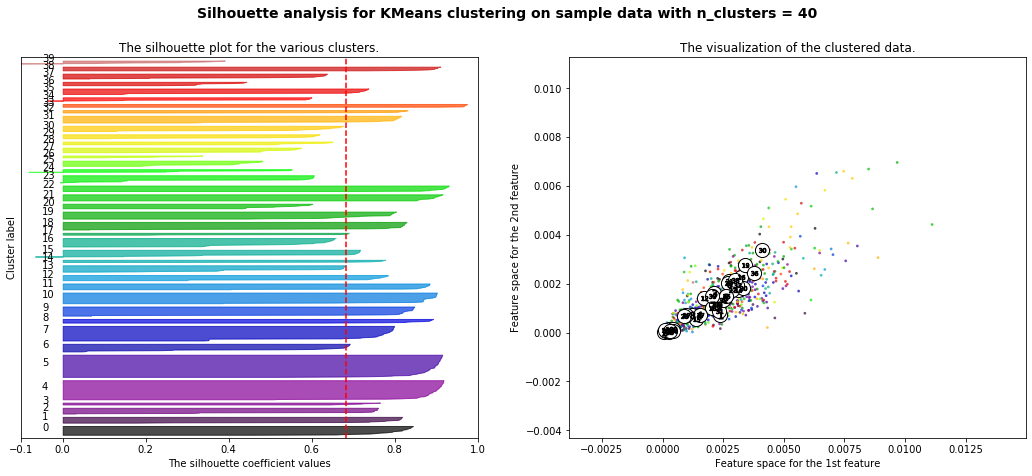

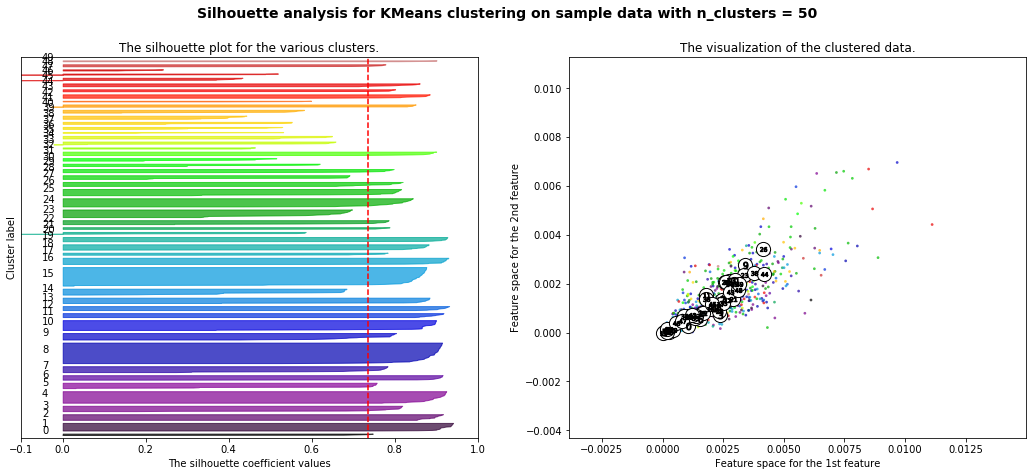

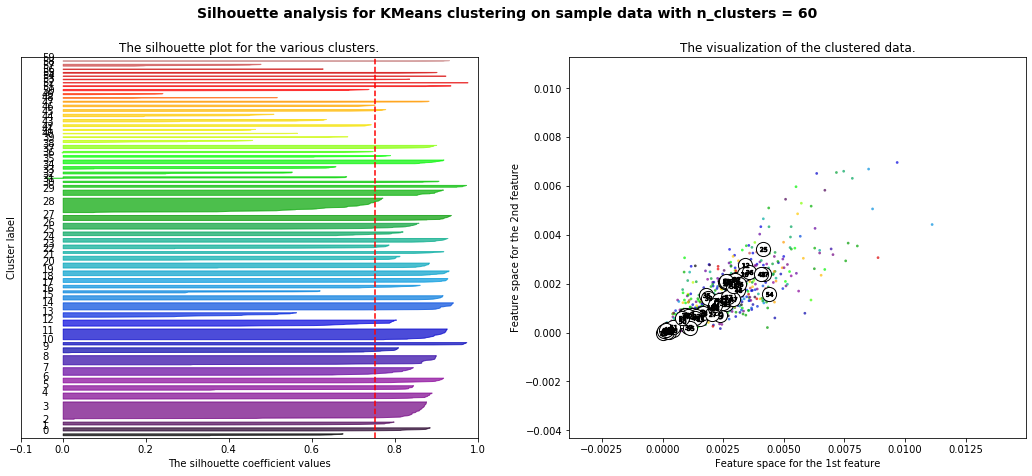

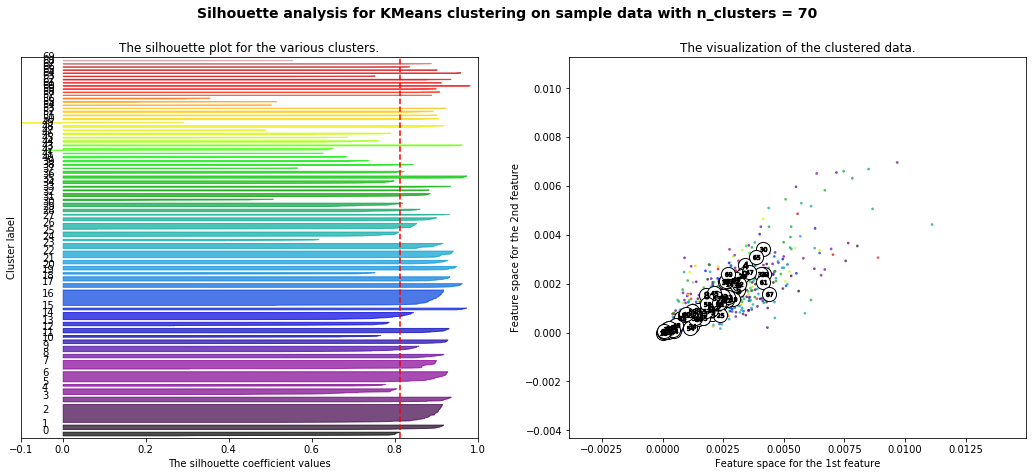

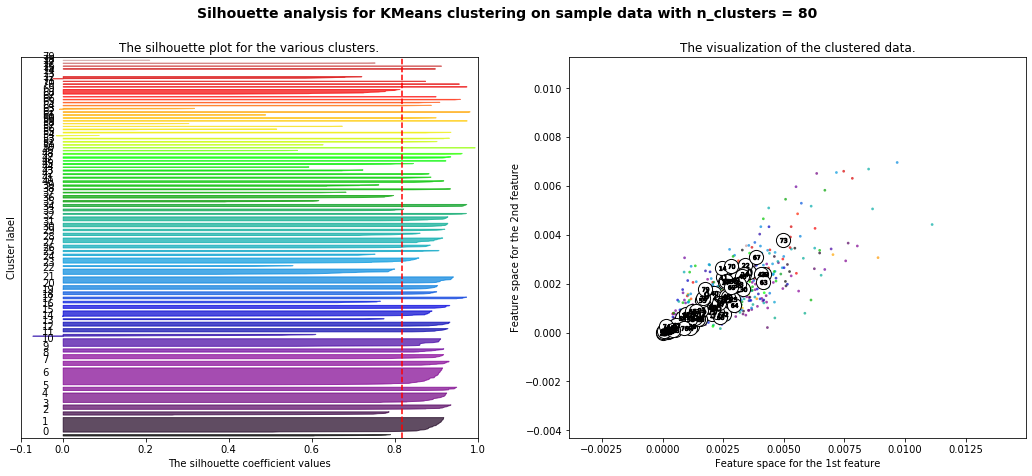

In [1389]:
show_cluster(df)